# 'Abstandsregel' vor und nach Covid-19 - eine Untersuchung mit Word2Vec

#### Bedeutung des Lemmas 'Abstandsregel'

Festlegung bzw. juristisch relevante Vorgabe einer einzuhaltenden Distanz zu etw., zu jmdm. bzw. zwischen bestimmten Objekten <br>
a) [Gesundheitswesen] Hygienemaßnahme, Vorschrift über einen einzuhaltenden Sicherheitsabstand zur Vermeidung einer Übertragung von Krankheitserregern <br>
b) [Verkehrswesen] den einzuhaltenden Sicherheitsabstand zwischen Verkehrsteilnehmern festlegende Vorgabe der gesetzlichen Bestimmungen über das Verhalten im Straßenverkehr <br>
(Quelle: https://www.dwds.de/wb/Abstandsregel) <br>
<br>
 

#### Hypothese

Durch die Pandemie und die daraus entstandenen Vorschriften zur Einhaltung eines Mindestabstands wird das Lemma populärer und die Bedeutung verschiebt sich von b) nach a). 

## Importe und Datenvorbereitung

In [1]:
import codecs
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns
import spacy
import statistics 

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from joblib import Parallel, delayed  
from nltk.corpus import stopwords
from scipy import spatial
from sklearn.manifold import TSNE
from tabulate import tabulate

In [2]:
nlp = spacy.load('de_core_news_md')
stopwords = stopwords.words('german')
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

#### Korpus laden und teilen

In [4]:
# die Datei enthält alle Treffer des Lemmas 'abstandsregel' im ZDL-Regionalkorpus des DWDS 
# mit jeweils einem Satz Kontext davor und danach

df = pd.read_csv('../../data/abstandsregel_1993-2021.csv', sep=',', encoding='utf-8')
df.head()

,Corpus,Date,Genre,Bibl,ContextBefore,Hit,ContextAfter
0,fr_regional,1995-02-20,Zeitung,"Frankfurter Rundschau, 20.02.1995","[...]aess geoeffnet werden"", bilanzierte das A...","Selbst an die sogenannte ""Abstandsregel"" halte...",Sie untersagt Wahlwerbung auf den letzten zehn...
1,saar_regional,1996-07-09,Zeitung,"Saarbrücker Zeitung, 09.07.1996",[...]t der schwarzen Aufschrift.,"""Leider halten sich viele nicht an die Abstand...",Die beiden Beamten arbeiten[...]
2,saar_regional,1996-07-09,Zeitung,"Saarbrücker Zeitung, 09.07.1996",NaN,Abstandsregeln Abstandsmessungen erfolgen auf ...,Abstandsregeln Abstandsmessungen erfolgen auf ...
3,saar_regional,1996-07-09,Zeitung,"Saarbrücker Zeitung, 09.07.1996",[...]standsmessungen erfolgen auf der Grundlag...,Abstandsregeln Abstandsmessungen erfolgen auf ...,"Der Abstand richtet sich nach Örtlichkeit, Str..."
4,saar_regional,1996-07-12,Zeitung,"Saarbrücker Zeitung, 12.07.1996",[...]t der schwarzen Aufschrift.,"""Leider halten sich viele nicht an die Abstand...",Die beiden Beamten arbeiten[...]


In [4]:
# NaN durch Whitespace ersetzen

df = df.fillna(' ')

In [5]:
# Wörter, die mit [...] anfangen löschen

expression = '\[...]\w*'
df = df.replace(to_replace = expression, value = ' ', regex=True)

In [6]:
# bevor die Spalten verbunden werden: Whitespace einfügen, um ein Aneinanderkleben der Wörter zu verhindern

df['ContextBefore'] = df['ContextBefore'].astype(str) + ' '
df['ContextAfter'] = ' ' + df['ContextAfter'].astype(str) 

In [7]:
# Text zu einer Spalte verbinden

columns = ['ContextBefore', 'Hit', 'ContextAfter']

df['Text'] = df[columns].astype(str).sum(axis=1)
df.head()

,Corpus,Date,Genre,Bibl,ContextBefore,Hit,ContextAfter,Text
0,fr_regional,1995-02-20,Zeitung,"Frankfurter Rundschau, 20.02.1995","geoeffnet werden"", bilanzierte das Amt.Zwisc...","Selbst an die sogenannte ""Abstandsregel"" halte...",Sie untersagt Wahlwerbung auf den letzten zeh...,"geoeffnet werden"", bilanzierte das Amt.Zwisc..."
1,saar_regional,1996-07-09,Zeitung,"Saarbrücker Zeitung, 09.07.1996",der schwarzen Aufschrift.,"""Leider halten sich viele nicht an die Abstand...",Die beiden Beamten arbeiten,"der schwarzen Aufschrift. ""Leider halten sic..."
2,saar_regional,1996-07-09,Zeitung,"Saarbrücker Zeitung, 09.07.1996",,Abstandsregeln Abstandsmessungen erfolgen auf ...,Abstandsregeln Abstandsmessungen erfolgen auf...,Abstandsregeln Abstandsmessungen erfolgen au...
3,saar_regional,1996-07-09,Zeitung,"Saarbrücker Zeitung, 09.07.1996",erfolgen auf der Grundlage einer...,Abstandsregeln Abstandsmessungen erfolgen auf ...,"Der Abstand richtet sich nach Örtlichkeit, St...",erfolgen auf der Grundlage einer... Abstands...
4,saar_regional,1996-07-12,Zeitung,"Saarbrücker Zeitung, 12.07.1996",der schwarzen Aufschrift.,"""Leider halten sich viele nicht an die Abstand...",Die beiden Beamten arbeiten,"der schwarzen Aufschrift. ""Leider halten sic..."


In [8]:
df.shape

(22794, 8)

In [19]:
# Korpus in 2 Teilkorpora splitten: vor und nach Covid-19 (dem Ausbruch in Deutschland)
# hier wurde die Grenze zwischen Januar und Februar 2020 gezogen (es wird sich noch zeigen, inwiefern sich das bewährt)

df_before_corona = df.iloc[:405,:]
df_after_corona = df.iloc[406:,:]

In [20]:
df_after_corona.head()

,Corpus,Date,Genre,Bibl,ContextBefore,Hit,ContextAfter,Text
406,neuw_regional,2020-02-04,Zeitung,"Neue Westfälische, 04.02.2020",Borgentreich.,In unserer gestrigen Berichterstattung zum The...,Für die Windvorrangzonen bei Bühne und Manrod...,Borgentreich. In unserer gestrigen Berichterst...
407,aaz_regional,2020-02-05,Zeitung,"Aachener Zeitung, 05.02.2020","""Es gibt kein verbrieftes Recht auf den freien...","Solange Abstandsregeln beachtet würden, sei da...",Michael Kleine würde dennoch immer zum Kompro...,"""Es gibt kein verbrieftes Recht auf den freien..."
408,sk_regional,2020-02-07,Zeitung,"Südkurier, 07.02.2020",in Pfullendorf bundesweit über 550 Spielhall...,Das Gesetz sieht neue Abstandsregeln für Spiel...,"Moßbrucker rechnet damit, dass etwa 50 Prozen...",in Pfullendorf bundesweit über 550 Spielhall...
409,mume_regional,2020-02-08,Zeitung,"Münchner Merkur, 08.02.2020",", die diese Regelung nicht haben, sprich mit ...",Die Abstandsregel sei auf Wunsch großer Teile ...,"""Über die Absolutheit von 10H kann man diskut...",", die diese Regelung nicht haben, sprich mit ..."
410,frt_regional,2020-02-08,Zeitung,"Fränkischer Tag, 08.02.2020",Gemeinderat Litzendorf will die Erweiterung de...,Knackpunkt könnte die Abstandsregel zu Wohnhäu...,Werner Höchstetter,Gemeinderat Litzendorf will die Erweiterung de...


#### Hilfsfunktionen zur Vorbereitung der Texte

In [21]:
def lemmatize_text_column(df, column):
    """
    transforms the Dataframe-column in a lemmatized string
    """
    text = ''
    for i in df[column]:
        doc = nlp(i)
        lemmas = ' '.join([x.lemma_ for x in doc])
        text = text + lemmas
    return text


def sentence_to_wordlist(raw:str):
    """
    cleans and tokenizes the sentences
    """
    text = re.sub('[^A-Za-z_äÄöÖüÜß]',' ', raw).split()
    filtered_text = [word for word in text if word not in stopwords]
    return filtered_text


def prepare_text(raw_text):
    """
    returns a list of tokenized sentences
    """
    raw_sentences = tokenizer.tokenize(str(raw_text).lower())    
    tokenized_sentences = Parallel(n_jobs=-1)(delayed(sentence_to_wordlist)(raw_sentence) for raw_sentence in raw_sentences)
    phrases = Phrases(tokenized_sentences)
    bigram = Phraser(phrases)
    sentences = list(bigram[tokenized_sentences])
    return sentences

#### Vorbereitung des ersten Texts (vor Covid-19)

In [22]:
text = lemmatize_text_column(df_before_corona, 'Text')
sentences = prepare_text(text)

# sentences ist eine Liste von tokenisierten Sätzen, zum Beispiel:
print(sentences[15])

['hoz', 'weihnachtsparkverbotjetzt', 'solch', 'bundesebene', 'regeln']


#### Vorbereitung des zweiten Texts (nach Covid-19)

In [23]:
text2 = lemmatize_text_column(df_after_corona, 'Text')
sentences2 = prepare_text(text2)

print(sentences2[100])

['sollen', 'dringend', 'notwendigkeit', 'benutzen']


## Training von Word2Vec auf den Text vor Covid-19

In [25]:
# Paramter setzen
workers = 4                      # Use these many worker threads to train the model (=faster training with multicore machines)
seed = 42                        # Seed for the random number generator

In [26]:
# Ordner anlegen zum Abspeichern von trainierten Modellen
if not os.path.exists('../../trained_models'):
    os.makedirs('../../trained_models')

In [27]:
# Training

w2v_bc = Word2Vec(sentences=sentences,                   
                 vector_size=300,          # Dimensionality of the word vectors
                 window=10,                # The maximum distance between the current and predicted word within a sentence
                 min_count=3,              # (int, optional) – The model ignores all words with total frequency lower than this
                 workers=workers, 
                 min_alpha=0.0001,         # Learning rate will linearly drop to min_alpha as training progresses
                 sg=1,                     # Training algorithm: skip-gram if sg=1, otherwise CBOW
                 seed=seed)

## Training von Word2Vec auf den Text nach Covid-19

In [28]:
w2v_ac = Word2Vec(sentences=sentences2,                   
                 vector_size=300,                
                 window=10,              
                 min_count=3,             
                 workers=workers, 
                 min_alpha=0.0001,                                                    
                 sg=1,                     
                 seed=seed)

In [29]:
# trainierte Modelle speichern
w2v_bc.save(os.path.join('../../trained_models', 'w2v_bc_abstandsregel.model'))
w2v_ac.save(os.path.join('../../trained_models', 'w2v_ac_abstandsregel.model'))

## Exploration und Vergleich der Embeddings

In [6]:
# trainierte Modelle laden
w2v_bc = Word2Vec.load(os.path.join('../../trained_models', 'w2v_bc_abstandsregel.model'))
w2v_ac = Word2Vec.load(os.path.join('../../trained_models', 'w2v_ac_abstandsregel.model'))

In [7]:
# ähnliche Wörter zu 'querdenker' vor Covid-19
w2v_bc.wv.most_similar(positive=['abstandsregel'], topn=25)

[('abstandsregeln', 0.9995710849761963),
 ('windkraftanlagen', 0.9993250370025635),
 ('jahr', 0.9992865324020386),
 ('weit', 0.9992807507514954),
 ('sollen', 0.9991781115531921),
 ('regel', 0.9991607666015625),
 ('anlage', 0.9991594552993774),
 ('neue', 0.9991584420204163),
 ('neu', 0.9991494417190552),
 ('neu_abstandsregeln', 0.9991443157196045),
 ('spielhallen', 0.9991360306739807),
 ('csu', 0.9991241693496704),
 ('alt', 0.9991123080253601),
 ('streng', 0.999075710773468),
 ('gelten', 0.9990652203559875),
 ('standort', 0.9990517497062683),
 ('land', 0.999036967754364),
 ('zwei', 0.9990256428718567),
 ('ab', 0.9990226030349731),
 ('windräder', 0.999014139175415),
 ('müssen', 0.9990114569664001),
 ('meter', 0.9990014433860779),
 ('mehr', 0.9989990592002869),
 ('kaum', 0.9989880919456482),
 ('energiewende', 0.9989877343177795)]

In [32]:
# ähnliche Wörter zu 'querdenker' nach Covid-19
w2v_ac.wv.most_similar(positive=['abstandsregel'], topn=25)

[('abstandsregel_meter', 0.772394061088562),
 ('regel', 0.7514543533325195),
 ('mindestabstand', 0.7507188320159912),
 ('abstandsregeln', 0.7445181608200073),
 ('abstand', 0.7403932213783264),
 ('zusätzlich', 0.7228553891181946),
 ('abstandsregel_eineinhalb', 0.7210496068000793),
 ('abstandsregel_mindestens', 0.7122260332107544),
 ('körperkontakt', 0.7095844149589539),
 ('sowohl', 0.7088636159896851),
 ('fahrgast', 0.7077032923698425),
 ('geschlossen_raum', 0.701336145401001),
 ('gebot', 0.6995812654495239),
 ('foyer', 0.6975014209747314),
 ('eingangsbereich', 0.6942217350006104),
 ('fahrt', 0.6932274103164673),
 ('sicherheitsabstand', 0.6890569925308228),
 ('meter', 0.6873124837875366),
 ('risiko', 0.6858959197998047),
 ('verzicht', 0.6855508089065552),
 ('beim_verlassen', 0.6855162978172302),
 ('zahlreiche', 0.6843019723892212),
 ('einerseits', 0.683091938495636),
 ('unterschiedlich_haushalt', 0.682589054107666),
 ('verbot', 0.6822670102119446)]

In [33]:
w2v_ac.wv.most_similar(positive=['virus'], topn=10)

[('niemand', 0.9606191515922546),
 ('vorbildlich', 0.9564299583435059),
 ('jemand', 0.949895441532135),
 ('demonstrant', 0.938120424747467),
 ('eher', 0.9317079186439514),
 ('feststellen', 0.926060140132904),
 ('verhalten', 0.9258441925048828),
 ('verständnis', 0.9258394837379456),
 ('supermarkt', 0.9255701899528503),
 ('wirklich', 0.9246327877044678)]

## Ausrichtung der beiden Embedding-Modelle

In [34]:
# Quelle: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Updatet script: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8
    Procrustes align two gensim models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.

    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)
    
    # re-filling the normed vectors
    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

In [35]:
# Ausrichtung des "After-Corona-Modells" an das "Before-Corona-Modell"

w2v_ac_al = smart_procrustes_align_gensim(w2v_bc, w2v_ac)

515 515
515 515


In [36]:
# speichern
w2v_ac_al.save(os.path.join('../../trained_models', 'w2v_ac_al_abstandsregel.model'))

## Cosinus-Ähnlichkeit zwischen den Vektoren der beiden Modelle

In [8]:
# laden
w2v_ac_al = Word2Vec.load(os.path.join('../../trained_models', 'w2v_ac_al_abstandsregel.model'))

#### Exploration

In [9]:
# ähnliche Wörter zu 'querdenker' nach Covid-19
w2v_ac_al.wv.most_similar(positive=['abstandsregel'], topn=25)

[('regel', 0.7514543533325195),
 ('mindestabstand', 0.750718891620636),
 ('abstandsregeln', 0.7445181608200073),
 ('abstand', 0.7403932213783264),
 ('meter', 0.6873124837875366),
 ('boden', 0.6776827573776245),
 ('generell', 0.6755607724189758),
 ('lediglich', 0.6753806471824646),
 ('grundsätzlich', 0.6713965535163879),
 ('regelung', 0.6655299067497253),
 ('festgelegt', 0.6641169190406799),
 ('verringern', 0.661136269569397),
 ('gesetzlich', 0.6586620807647705),
 ('beispielsweise', 0.6530029773712158),
 ('erhöhen', 0.652286946773529),
 ('entfernen', 0.65088951587677),
 ('gehören', 0.650300920009613),
 ('gelingen', 0.6474153995513916),
 ('hoch', 0.6468162536621094),
 ('rechtlich', 0.6464312076568604),
 ('vorgabe', 0.6425298452377319),
 ('ausnahme', 0.6417384147644043),
 ('bahn', 0.6413413286209106),
 ('bestehend', 0.6399807929992676),
 ('passieren', 0.635582685470581)]

In [10]:
vector_abstandsregel_bc = w2v_bc.wv['abstandsregel']  
vector_abstandsregel_ac_al = w2v_ac_al.wv['abstandsregel'] 

cosine_abstandsregel = 1 - spatial.distance.cosine(vector_abstandsregel_bc, vector_abstandsregel_ac_al)
cosine_abstandsregel

0.5814823508262634

### durchschnittliche Cosinus-Ähnlichkeit und 5%-Quantil

- von allen Wörtern/Vektoren, die in beiden Modellen vorkommen jeweils die Cosinus-Ähnlichkeit berechnen (d.h. zueinander zwischen den Modellen
- 5%-Quantil berechnen zur Überprüfung von statistischer Signifikanz
- liegt der Wert der Cosinus-Ähnlichkeit (desselben Lemmas zwischen den Modellen) unter dem 5%-Quantil?

In [13]:
# alle Wörter, die in beiden Modellen vorkommmen

vocab_bc = set(w2v_bc.wv.index_to_key)
vocab_ac_al = set(w2v_ac_al.wv.index_to_key)

common_vocab = vocab_bc & vocab_ac_al

In [14]:
len(common_vocab)

515

In [15]:
# Cosinus-Ähnlichkeit zwischen dem Wort in den beiden Modellen berechnen

cosines = {}

for word in common_vocab:
    vector_bc = w2v_bc.wv[word]  
    vector_ac_al = w2v_ac_al.wv[word] 
    cosine = 1 - spatial.distance.cosine(vector_bc, vector_ac_al)
    cosines[word] = cosine

In [16]:
cosine_df = pd.DataFrame.from_dict(cosines, orient='index', columns=['cosine'])
cosine_df

,cosine
bundesländer,0.978400
staatsregierung,0.974788
übrigens,0.922042
müssen,0.632455
horst,0.970455
...,...
energie,0.984278
bundesländern,0.975233
verstoß,0.783405
reagieren,0.949041


In [17]:
# durchschnittliche Cosinus-Ähnlichkeit der Wörter der beiden Modelle 

statistics.mean(cosine_df['cosine'])

0.8761961601891564

In [19]:
# Median

statistics.median(cosine_df['cosine'])

0.9047220349311829

In [20]:
# Standardabweichung

statistics.stdev(cosine_df['cosine'])

0.10212023796129951

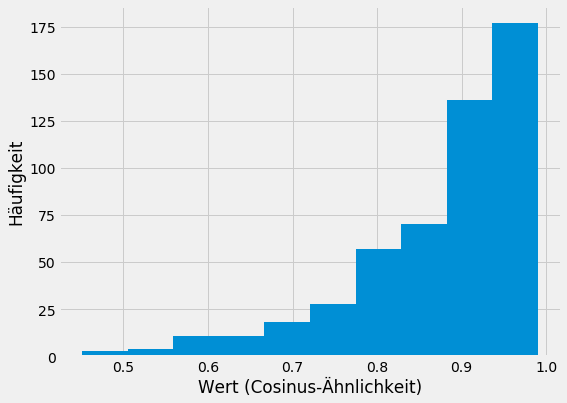

In [24]:
# Verteilung der Cosinus-Ähnlichkeit der Wörter der beiden Modelle als Histogramm

plt.figure(figsize=[8, 6])
plt.style.use('fivethirtyeight')
plt.hist(cosine_df['cosine'])
plt.xlabel('Wert (Cosinus-Ähnlichkeit)')
plt.ylabel('Häufigkeit')
plt.show()

In [32]:
# 5%-Quantil

border = np.quantile(cosine_df['cosine'], 0.05)
border

0.652020287513733

### Ergebnis

In [33]:
cosine_abstandsregel < border

True

Die Cosinus-Ähnlichkeit zwischen den beiden Vektoren für 'Abstandsregel' liegt unterhalb des 5%-Quantils. <br>
Die Hypothese kann als verifiziert gelten. 